In [2]:
#########################################################################
# Imports
#########################################################################
import os
from ultralytics import YOLO
import hyperparams as hp

from utils import eda_detect_class_distribution, eda_detect_visualize_boxes, eda_detect_box_aspect_ratio, eda_detect_heatmap, fix_dataset_yaml, eval_detect_curves, eval_detect_performance_plots, eval_detect_metrics, eval_detect_visual_preds


Starting Detection EDA...
Generating Detection Class Distribution (including Background/Clean)...


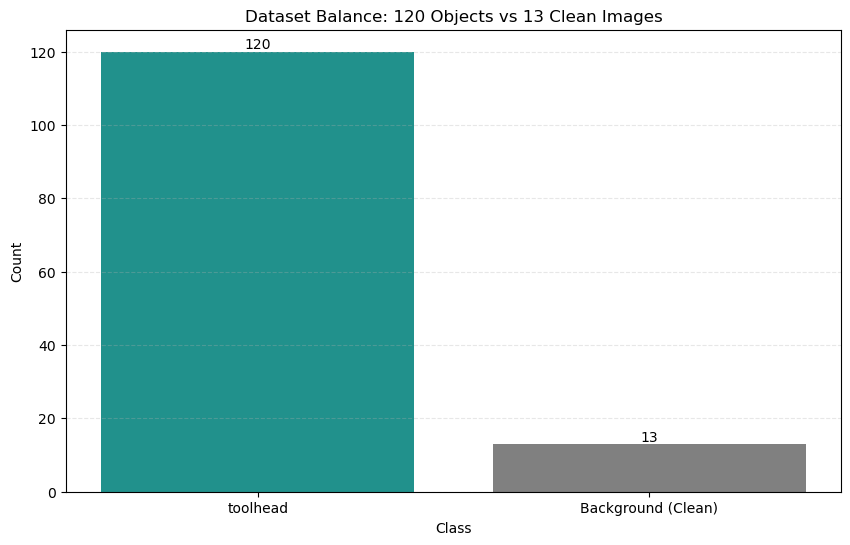

Visualizing 6 random samples with Ground Truth boxes...


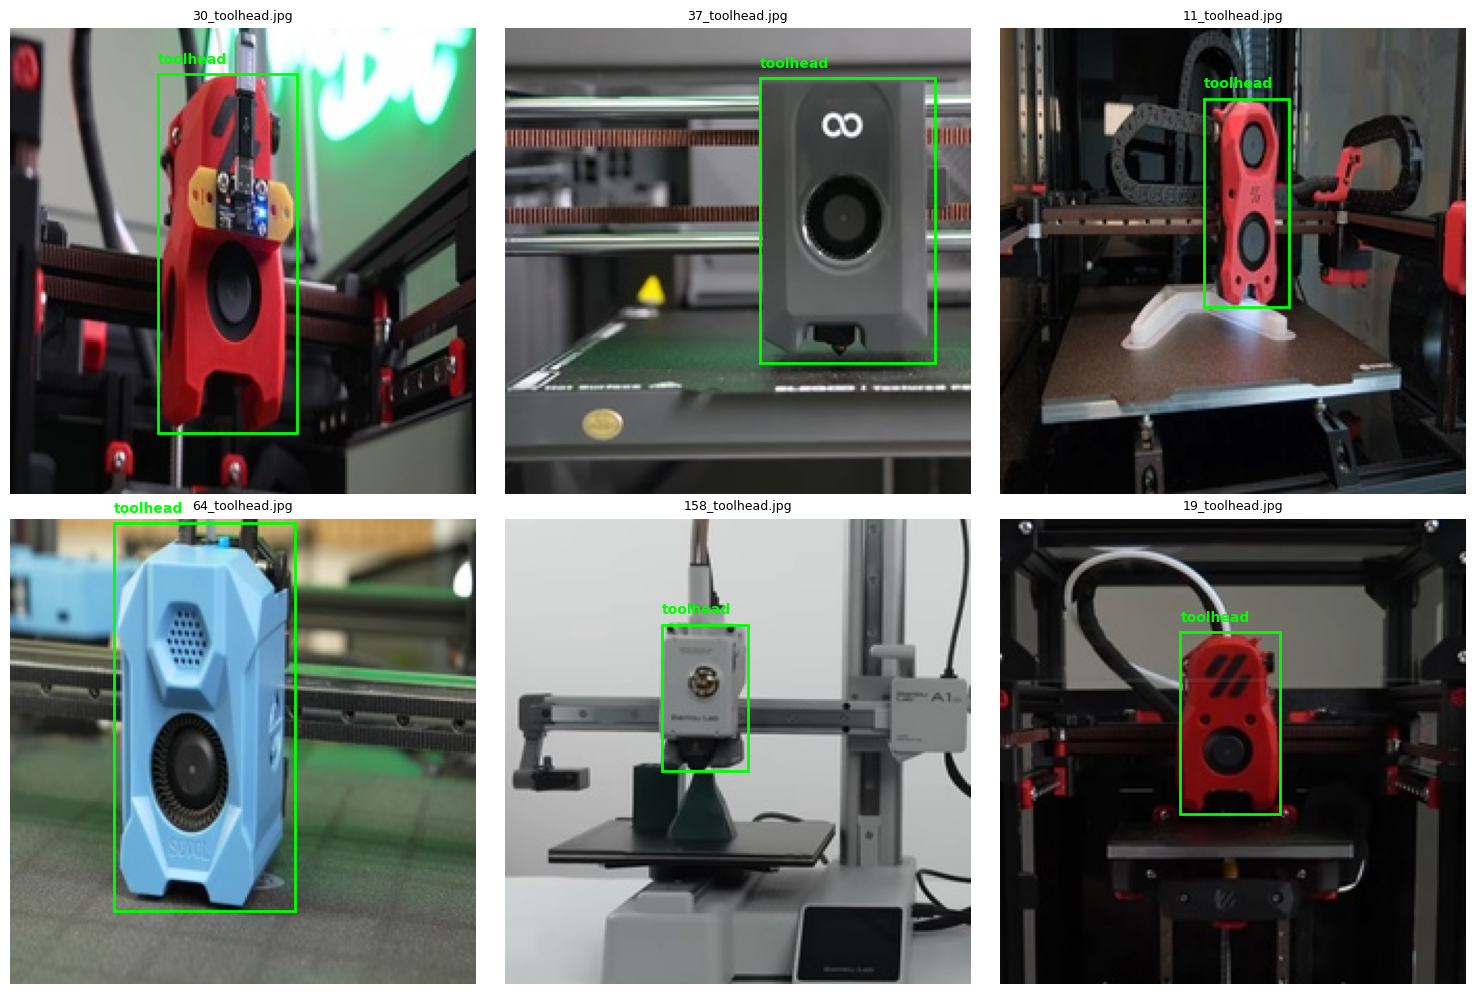

Analyzing Box Aspect Ratios...


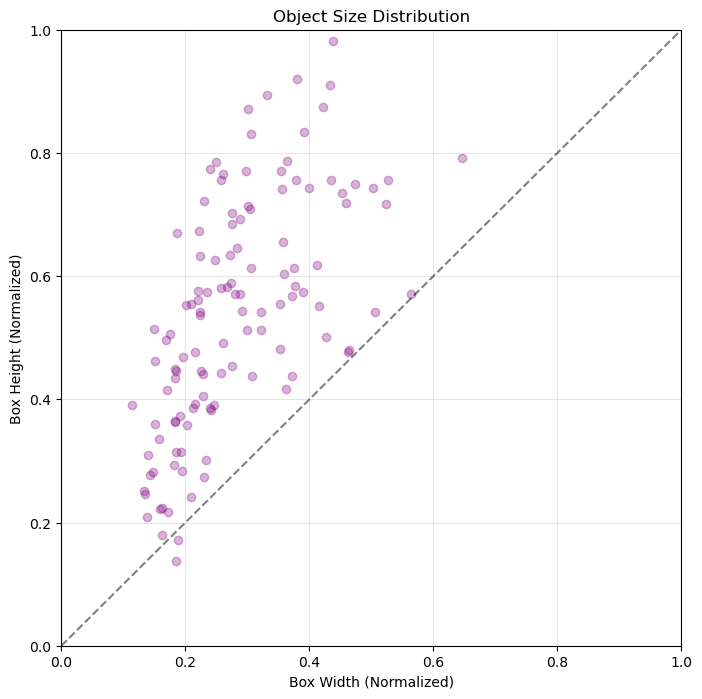

Generating Object Location Heatmap (Hexbin)...


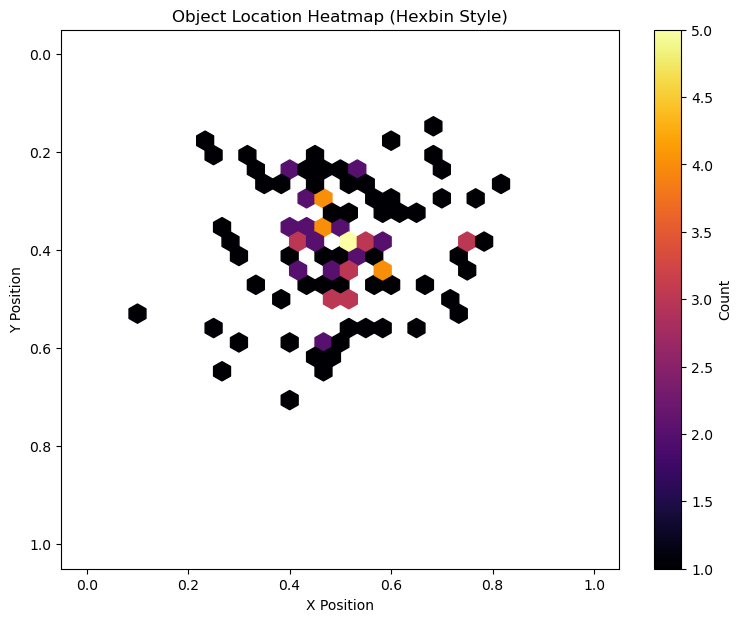

In [2]:
#########################################################################
# Exploratory Data Analysis (EDA)
#########################################################################
print("Starting Detection EDA...")

# Check Class Balance
eda_detect_class_distribution(hp.DATA_YAML)

# Visual Sanity Check (Ground Truth)
eda_detect_visualize_boxes(hp.DATA_YAML, num_samples=6)

# Object Size & Shape Analysis
# WHY: YOLO uses "anchors" (preset box shapes). If all your objects are tall and thin,
# but YOLO expects square boxes, it will struggle. This plot tells us if we need to
# change image size or trust the auto-anchor computation.
eda_detect_box_aspect_ratio(hp.DATA_YAML)

# 4. Location Heatmap
# WHY: If all your toolheads are perfectly centered in every image, the model might
# fail when the toolhead is in a corner. If the heatmap is a single hot dot in the center,
# we rely heavily on Mosaic Augmentation to fix this.
eda_detect_heatmap(hp.DATA_YAML)

In [4]:
#########################################################################
#   Yolo26 finetuning training
#########################################################################

fix_dataset_yaml(hp.DATA_YAML)

print(f"Loading model with weights at: {hp.PATH_WEIGHTS_YOLO}")
model = YOLO(hp.PATH_WEIGHTS_YOLO)
print(f"Model loaded: {model}")

results = model.train(
        data=hp.DATA_YAML,
        imgsz=hp.IMG_SIZE,
        epochs=hp.EPOCHS,
        batch=hp.BATCH_SIZE,
        project=hp.PATH_BASE,
        name=hp.FINAL_WEIGHTS_NAME,
        device=0,
        
        # Augmentatuions
        mosaic=hp.AUG_MOSAIC,
        mixup=hp.AUG_MIXUP,         
        degrees=hp.AUG_ROTATION_DEGREES,      
        translate=hp.AUG_TRANSLATE,     
        scale=hp.AUG_SCALE,         
        fliplr=hp.AUG_FLIP_LR,
        
        # additional optimization
        patience=hp.OPT_PAITENCE,       
        exist_ok=True,     
        verbose=True
    )

print("Training complete.")

Fixing paths in: /home/yuri/projects/SpaghettiNet_3D-printer-spaghetti-detection/datasets/detection/dataset/dataset.yaml
✅ Updated 'path' in yaml to: /home/yuri/projects/SpaghettiNet_3D-printer-spaghetti-detection/datasets/detection/dataset
Loading model with weights at: /home/yuri/projects/SpaghettiNet_3D-printer-spaghetti-detection/models/detection/yolo26n.pt
Model loaded: YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32

Starting Detection Evaluation...


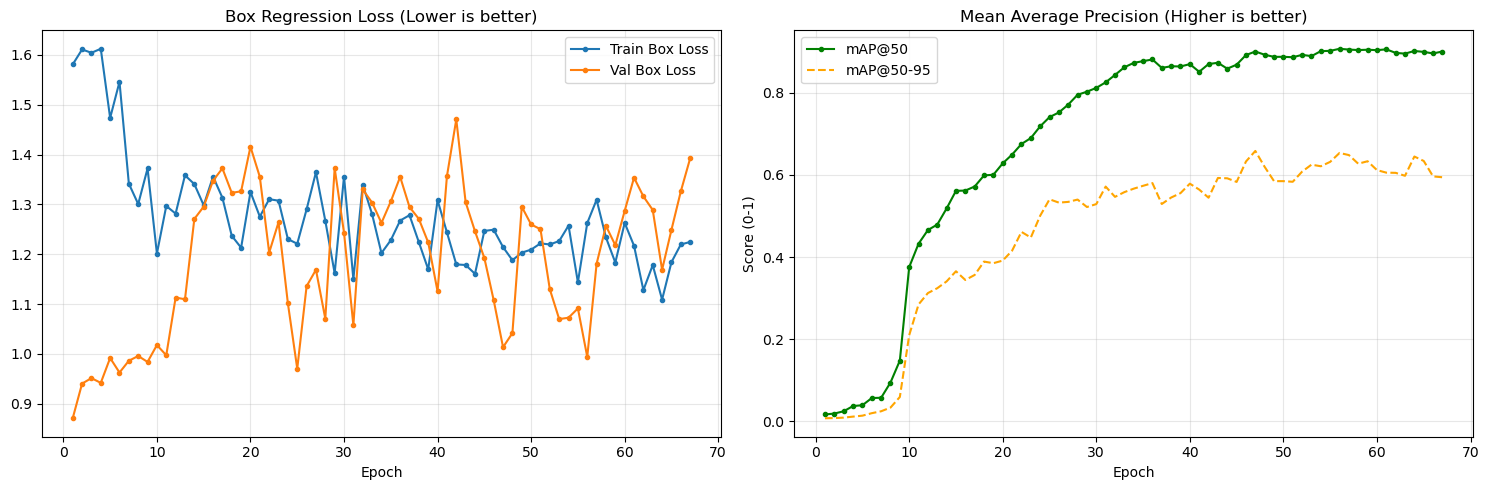

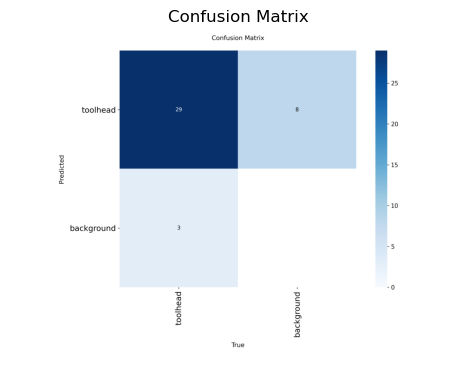

Running Official Validation...
Ultralytics 8.4.3 🚀 Python-3.11.14 torch-2.9.1+rocm6.4 CUDA:0 (AMD Radeon RX 6800 XT, 16368MiB)
YOLO26n summary (fused): 122 layers, 2,375,031 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1419.6±463.6 MB/s, size: 19.8 KB)
val: Scanning /home/yuri/projects/SpaghettiNet_3D-printer-spaghetti-detection/datasets/detection/dataset/labels/val.cache... 38 images, 6 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 38/38 13.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 19.6it/s 0.2s.2s
                   all         38         32      0.864      0.781        0.9      0.657
Speed: 0.3ms preprocess, 1.9ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to /home/yuri/projects/SpaghettiNet_3D-printer-spaghetti-detection/models/detection/runs/detect/val4

=== FINAL DETECTION METRICS ===
mAP@50    (PASCAL VOC metric): 0.8998
mAP@50-95 (COCO metric)      : 

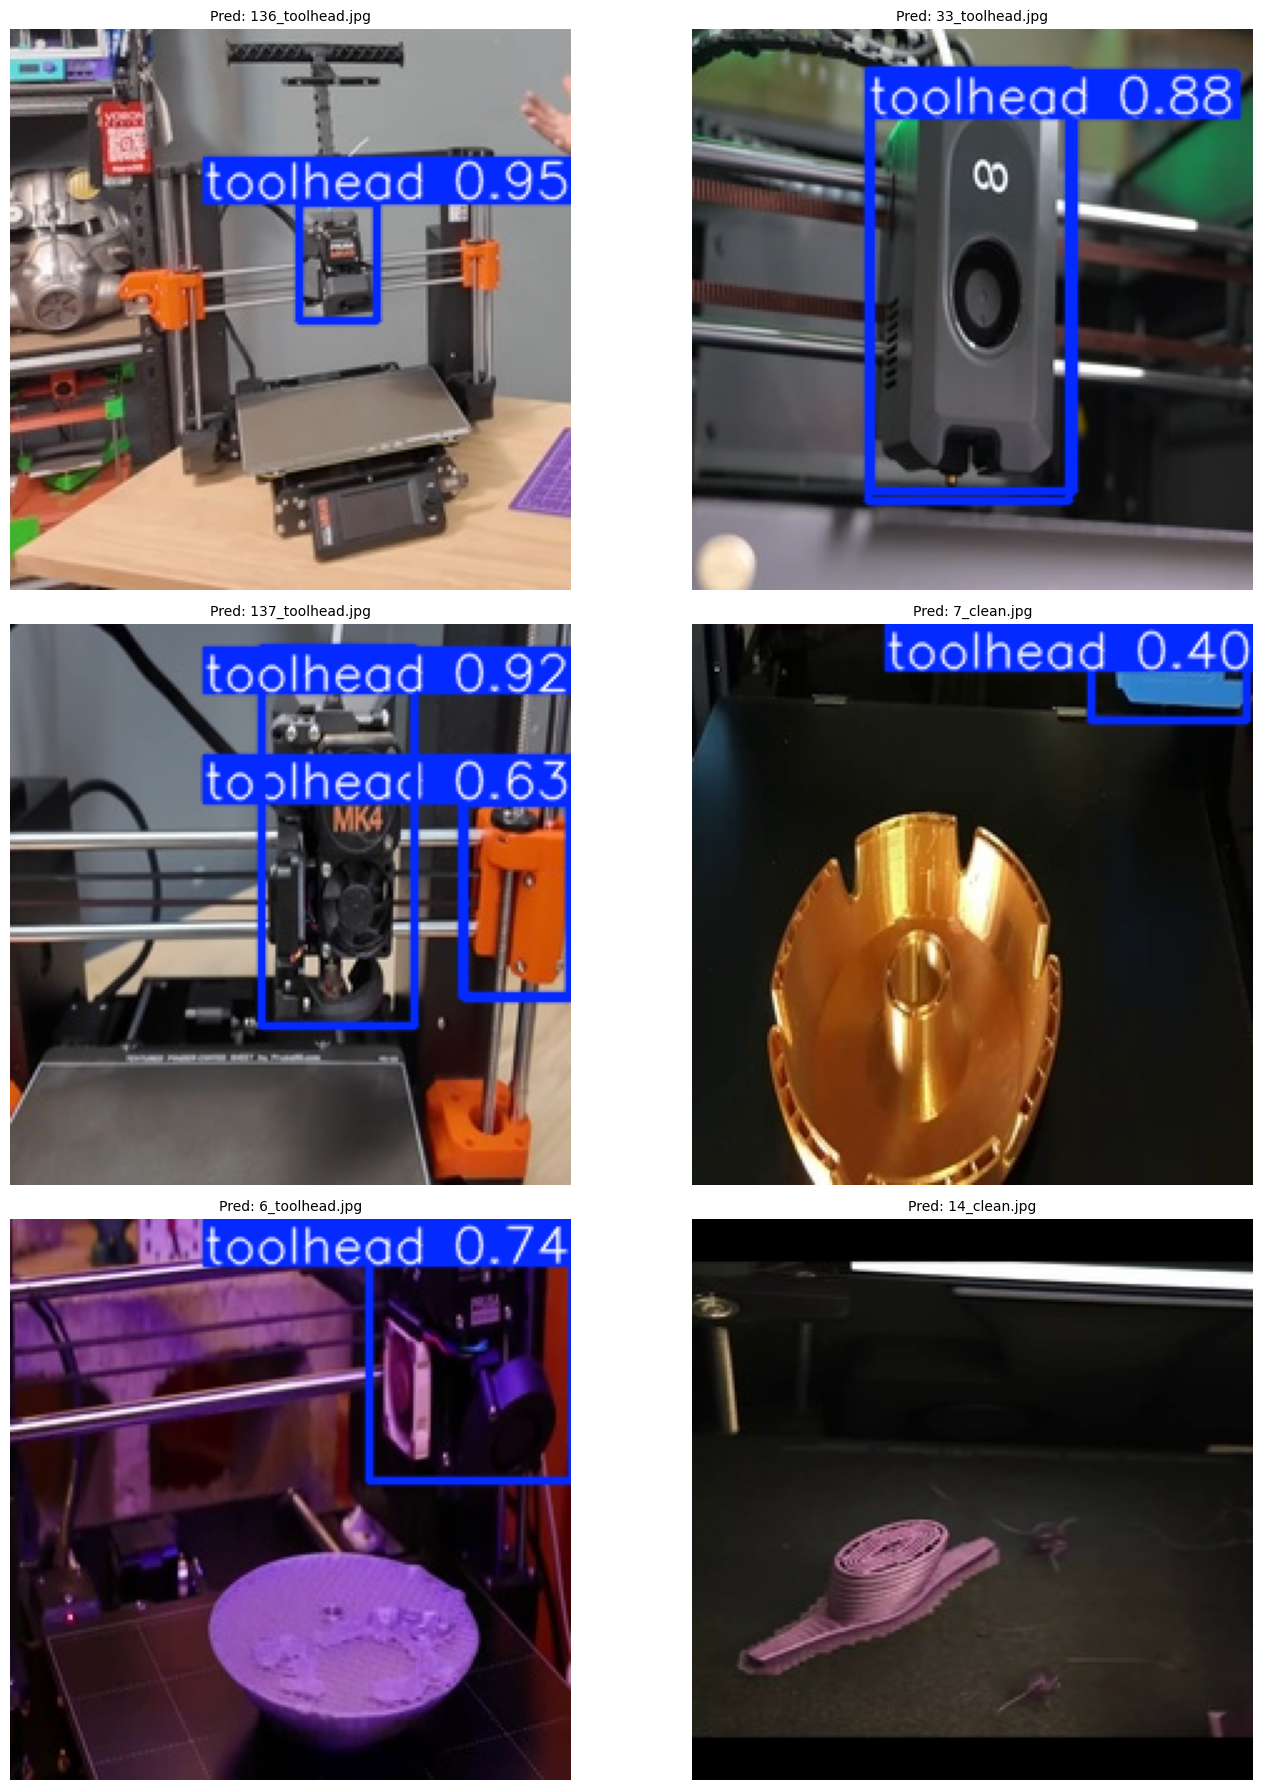

In [6]:
##########################################################################
#  Evaluation
##########################################################################
print("Starting Detection Evaluation...")

# 1. Training Dynamics
# WHY: We check 'Box Loss' to see if the model learned to draw tighter boxes over time.
# We check 'mAP' (Mean Average Precision) to see overall accuracy improvement.
eval_detect_curves()

# 2. Advanced Performance Plots
# WHY: 
# - Confusion Matrix: Did it think the background was a toolhead?
# - F1 Curve: Tells us the optimal Confidence Threshold. 
#   (e.g., if the peak is at 0.4, we should ignore predictions below 40%).
eval_detect_performance_plots()

# 3. Official Metrics
# WHY: These are the numbers you put in your report/thesis.
# mAP@50 is the standard "did I find the object?" metric.
# mAP@50-95 is the strict "did I find the object perfectly aligned?" metric.
eval_detect_metrics()

# 4. The Eye Test
# WHY: Numbers lie, images don't. We run the model on unseen images 
# to see if the boxes are actually wrapping the toolhead correctly.
eval_detect_visual_preds(num_samples=6)